In [29]:
import numpy as np
from tqdm.notebook import tqdm
import trimesh
from queue import PriorityQueue
import matplotlib.pyplot as plt
from make_vtk import write_lines_to_vtk
# import cupy as cp

In [30]:
lh_white_vertices = np.load('./data/lh_white_vertices.npy')
lh_white_faces = np.load('./data/lh_white_faces.npy')
lh_white_vertex_normals = np.load('./data/lh_white_vertex_normals.npy')
lh_pial_vertices = np.load('./data/lh_pial_vertices.npy')
lh_pial_faces = np.load('./data/lh_pial_faces.npy')


print(lh_white_vertices.shape)
print(lh_white_faces.shape)
print(lh_white_vertex_normals.shape)
print(lh_pial_vertices.shape)
print(lh_pial_faces.shape)

(142422, 3)
(284840, 3)
(142422, 3)
(142422, 3)
(284840, 3)


In [67]:
import trimesh
import numpy as np

# white 2 pial directions
white2pial_dir = lh_pial_vertices - lh_white_vertices

# Load the origin and target meshes
origin_mesh = trimesh.Trimesh(vertices=lh_white_vertices, faces=lh_white_faces)
target_mesh = trimesh.Trimesh(vertices=lh_pial_vertices, faces=lh_pial_faces)

# Create the meshes
origin_mesh = trimesh.Trimesh(vertices=lh_white_vertices, faces=lh_white_faces)
target_mesh = trimesh.Trimesh(vertices=lh_pial_vertices, faces=lh_pial_faces)

# Create intersectors for both meshes
origin_intersector = trimesh.ray.ray_pyembree.RayMeshIntersector(origin_mesh)
target_intersector = trimesh.ray.ray_pyembree.RayMeshIntersector(target_mesh)

# For each vertex in the origin mesh, shoot a ray in the direction of its normal
origins = origin_mesh.vertices
directions = origin_mesh.vertex_normals

# Get self - intersections   # trimesh는 스스로 겹치는 것은 취급을 안한다. 
self_locations, self_index_ray, self_index_tri = origin_intersector.intersects_location(
    origins,
    directions, 
    multiple_hits=True)

# Get intersections
locations, index_ray, index_tri = target_intersector.intersects_location(
    origins,
    directions, 
    multiple_hits=True)

print(locations.shape)
print(index_ray.shape)

thickness = []
self_intersect_idx = []
not_intersect_idx = []

self_intersect_pos = self_locations
self_origin_pos = origins[self_index_ray]
self_directions_vector = directions[self_index_ray]

self_distances = np.sqrt(np.sum((self_intersect_pos - self_origin_pos)**2,axis=1)) 


intersect_pos = locations                    # ( 530738 , 3 ) 
origin_pos = origins[index_ray]              # ( 530738 , 3 ) 
directions_vector = directions[index_ray]    # ( 530738 , 3 ) 

threshold = 7

distances = np.sqrt(np.sum((intersect_pos - origin_pos)**2,axis=1))   # ( 530738 ,  ) 

pair = []
too_long = []
too_long_pair = []



for i in tqdm(range(len(origins))):

  if i in index_ray :     # white에서 pial intersect 있을 때 

    if i in self_index_ray:     # self intersect 할때
            
      
      white2pial_d = white2pial_dir[i]
      
      self_idx = np.where(self_index_ray == i)[0]
      self_temp_dist = self_distances[self_idx]
      temp_self_direction_vetors = self_directions_vector[self_idx]
      self_sign_mask = np.dot(temp_self_direction_vetors,white2pial_d) > 0 
      try : 
        self_mask_index = np.nonzero(self_sign_mask)[0][np.argmin(self_temp_dist[self_sign_mask])]
        self_smallest_dist= self_temp_dist[self_mask_index]
        
      except : 
        self_smallest_dist = float('inf')
      

      idx = np.where(index_ray == i)[0]
      temp_dist = distances[idx]
      # smallest_dist= np.min(temp_dist)
      # smallest_dist_idx = np.argmin(temp_dist)
      # real_idx = idx[smallest_dist_idx]
      
      temp_direction_vetors = directions_vector[idx]
      real_sign = np.dot(temp_direction_vetors,white2pial_d) > 0 
      
      try : 
        smallest_index = np.nonzero(real_sign)[0][np.argmin(temp_dist[real_sign])]
        smallest_dist = temp_dist[smallest_index]
      except : 
        smallest_dist = np.nan
        
      if smallest_dist != np.nan : 
        real_idx = idx[smallest_index]
        
        
      if (self_smallest_dist == float('inf')) and (np.isnan(smallest_dist)):
        thickness.append(np.nan)
        not_intersect_idx.append(i)
        

      elif self_smallest_dist < smallest_dist : 
        thickness.append(np.nan)
        self_intersect_idx.append(i)

      
      elif smallest_dist > threshold: 
        thickness.append(np.nan)
        too_long.append(i)
        too_long_pair.append((origin_pos[real_idx],intersect_pos[real_idx]))

      else : 
        thickness.append(smallest_dist)
        pair.append((origin_pos[real_idx],intersect_pos[real_idx]))

    else : 
      idx = np.where(index_ray == i)[0]
      temp_dist = distances[idx]
      temp_direction_vetors = directions_vector[idx]
      real_sign = np.dot(temp_direction_vetors,white2pial_d) > 0 
      
      try : 
        smallest_index = np.nonzero(real_sign)[0][np.argmin(temp_dist[real_sign])]
        smallest_dist = temp_dist[smallest_index]
      except : 
        smallest_dist = np.nan
        
      if smallest_dist != np.nan : 
        real_idx = idx[smallest_index]
        
      
      if (self_smallest_dist == float('inf')) and (np.isnan(smallest_dist)):
        thickness.append(np.nan)
        not_intersect_idx.append(i)

      elif smallest_dist > threshold: 
        thickness.append(np.nan)
        too_long.append(i)
        too_long_pair.append((origin_pos[real_idx],intersect_pos[real_idx]))

      else : 
        thickness.append(smallest_dist)
        pair.append((origin_pos[real_idx],intersect_pos[real_idx]))

  else : 
    thickness.append(np.nan)
    not_intersect_idx.append(i)

thickness = np.array(thickness)
print(len(thickness))
print(max(thickness))
print(thickness)



full_range = np.arange(0,len(origins)-1)
missing_numbers = np.setdiff1d(full_range, index_ray)




(530738, 3)
(530738,)


  0%|          | 0/142422 [00:00<?, ?it/s]

IndexError: index 1 is out of bounds for axis 0 with size 1

In [48]:
vertex_num = len(thickness)
num_nans = np.sum(np.isnan(thickness))
valid_thickness_num = vertex_num - num_nans
self_intersect_num = len(self_intersect_idx)
removed_by_threshold = len(too_long)
not_intersect_num = len(not_intersect_idx)



print(f'threshold : {threshold}')
print(f'vertices num : {vertex_num}')
print(f'valid thickness num : {valid_thickness_num}')
print(f'num nan : {num_nans}\n')

print(f'---  num nan Specify ---')
print(f'self intersect num : {self_intersect_num}')
print(f'removed by threshold : {removed_by_threshold}')
print(f'not intersect num : {not_intersect_num}')

# print(f'all : {self_intersect_num + removed_by_threshold + not_intersect_num}')


threshold : 7
vertices num : 142422
valid thickness num : 70399
num nan : 72023

---  num nan Specify ---
self intersect num : 69750
removed by threshold : 1924
not intersect num : 349


In [49]:
write_lines_to_vtk(pair, f"./vtk_file/pair_line_{threshold}.vtk")
write_lines_to_vtk(too_long_pair, f"./vtk_file/long_line_{threshold}.vtk")

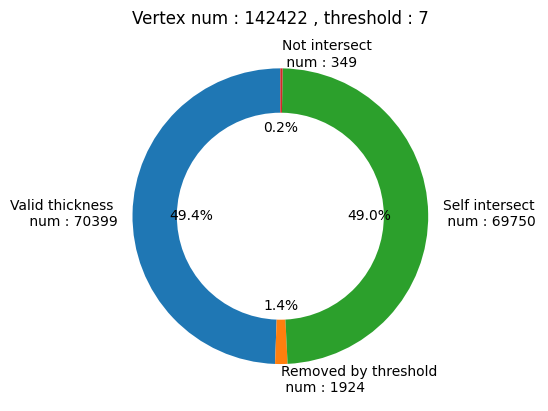

In [50]:
plot_data = [valid_thickness_num,removed_by_threshold,self_intersect_num,not_intersect_num]

labels = [f"Valid thickness \n num : {valid_thickness_num}",
          f"Removed by threshold \n num : {removed_by_threshold}", 
          f"Self intersect \n num : {self_intersect_num}",
          f"Not intersect \n num : {not_intersect_num}"]


# Create a pie chart
fig, ax = plt.subplots()
ax.pie(plot_data, labels=labels, startangle=90, wedgeprops=dict(width=0.3), autopct='%1.1f%%')

# Display
plt.title(f"Vertex num : {vertex_num} , threshold : {threshold}")
plt.show()

In [16]:
from vtk_revise import read_vtk



lh_white = read_vtk('./vtk_file/subj_1_lh_white.vtk')


new_thickness = lh_white['new_thickness']

print(new_thickness)

num_zero = len(np.where(new_thickness==0)[0])
num_nans = np.sum(np.isnan(new_thickness))
print(num_zero)
print(num_nans)


[3.18507367 0.         3.35244491 ... 0.         3.63713319 0.        ]
72323
0


In [62]:
import numpy as np

# Example array
arr = np.array([0, 5, -1, 3, -7, 2, -8, -15])

# Create a boolean mask for positive values
mask = arr > 0

# Get the index of the minimum positive value
index = np.nonzero(mask)[0][np.argmin(arr[mask])]

print(index)
print(arr[mask])


5
[5 3 2]
